# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 ноября 2017, 23:59   
**Штраф за опоздание:** -2 балла после 23:59  4 декабря, -4 балла после 23:59 11 декабря, -6 баллов после 23:59 18 декабря

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Разбаловка:**   
За задание можно получить 10 баллов. Для этого нужно следующее:
1. Там, где написано "Ваш код", нужно реализовать метод или часть метода
2. Там, где написано "Что делает этот блок кода?", нужно разобраться в блоке кода и в комментарии написать, что он делает    
3. Добиться, чтобы в пункте "Проверка скорости работы" Ваша реализация работала чуть быстрее, чем у дерева из sklearn
4. Добиться, чтобы в пункте "Проверка качества работы" Ваша реализация работала качественнее, чем у дерева из sklearn

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    # min_samples_split : Минимальное количество выборок, необходимое для разделения внутреннего узла.

    # max_depth : Максимальная глубина дерева. Если "None", то то узлы расширяются до тех пор,
    # пока все листья не станут чистыми, или пока все листья не будут содержать меньше, чем min_samples_split элементов.

    # sufficient_share : "достаточная доля": если, например, она равна 0.7, и там больше 70% объектов принадлежат
    # определенному кластеру, то считаем, что этот лист и возвращает данный кластер.

    # max_features : Количество признаков, которые нужно учитывать для лучшего разделения.

    # criterion : необходим для оценки качества разбиения.

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print 'invalid criterion name'
            # Искусственная генерация сообщения об ошибке.
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print 'invalid max_features name'
            raise

            
    def __gini(self, l_c, l_s, r_c, r_s):
        
        # ".astype" casts to a specified type.
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        
        return 1 - np.sum( (l_c ** 2 / l_s) + (r_c ** 2 / r_s), axis=1)
    
    
    def __entropy(self, l_c, l_s, r_c, r_s):

        eps = 1e-8
        return -np.sum( (l_c * np.log(l_c / l_s + eps)) + (r_c * np.log(r_c / r_s + eps)), axis=1 ).reshape(-1, 1) / (l_s + r_s)
        
      
    def __misclass(self, l_c, l_s, r_c, r_s):
        
        return 1 - (l_c.max(axis=1) + r_c.max(axis=1)) / (l_s + r_s).ravel()
      

    def __get_feature_ids_sqrt(self, n_feature):
        
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        
        return feature_ids[:int(np.sqrt(n_feature))]
    
        
    def __get_feature_ids_log2(self, n_feature):
        
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        
        return feature_ids[:int(np.log2(n_feature))]
    
    
    def __get_feature_ids_N(self, n_feature):
        
        return range(n_feature)
    
    # Сортировка векторов x и y по значениям x.
    def __sort_samples(self, x, y):
        
        # ".argsort" returns the indices that would sort an array.
        sorted_idx = x.argsort()
        
        return x[sorted_idx], y[sorted_idx]
    
    # Разделение выборки на две по величине threshold для feature_id.
    def __div_samples(self, x, y, feature_id, threshold):
        
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        
        # Получаем x и y, отсортированные по возрастанию значений выбранного признака x.
        sorted_x, sorted_y = self.__sort_samples(x, y)
        
        # Определение количества уникальных классов в выборке (векторе y), которую передали на вход.
        class_number = np.unique(y).shape[0]
                
        # В отсортированном массиве отступаем от его концов так, чтобы далее проверить, больше ли в векторе элементов,
        # чем допустимое минимальное значение min_samples_split. 
        splitted_sorted_y = sorted_y[self.min_samples_split:-self.min_samples_split]
        
        # Создание вектора с аргументами, в которых меняется значение кластера с одного на другой.
        # "np.where" returns elements, either from x or y, depending on condition.
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (self.min_samples_split + 1)
        
        # Если все классы в splitted_sorted_y одинаковые, то разбиение не требуется.
        if len(r_border_ids) == 0:
            
            return float('+inf'), None
        
        # Количество элементов в группах подряд идущих элементов из одного класса (кроме последнего)    
        eq_el_count = r_border_ids - np.append([self.min_samples_split], r_border_ids[:-1])
        
        # Сначала создается матрица в которую для каждой строки (т.е. разбиения) записывается длина вхождений того или иного класса. 

        # Находит матрицу class_increments: строки - номера концов из r_border_ids, столбцы - классы.
        # В [i, j] ячейке записано число элементов класса j, которые перейдут в левую часть разбиения,
        # когда мы повысим порог так, чтобы взять в эту часть ещё одну i-ю группу. 
        
        # [i, j] = n, если i-й отрезок - имеет n элементов номера j.
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        # Добавляем, что отрезали в splitted_sorted_y.
        class_increments[0] = class_increments[0] + np.bincount(y[:self.min_samples_split], minlength=class_number)
        
        # Определение количества элементов j-го класса, оставшихся при разбиении в левой и правой ветвях.
        # "np.cumsum" returns the cumulative sum of the elements along a given axis.
        l_class_count = np.cumsum(class_increments, axis=0)
        
        # Аналогично для правого класса вычитание из общего количества элементов j-го класса.
        # "np.bincount" counts number of occurrences of each value in array of non-negative ints.
        r_class_count = np.bincount(y) - l_class_count
        
        # В строках матриц l_sizes и r_sizes записывается число элементов левого и правого класса при разбиении.
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes

        # Получение вектора меры неопределённости (impurity) для вероятных разбиений и выбор разбиения с минимальной мерой.
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)
    
        # Номер элемента, с которого начинается правый класс.
        left_el_id = l_sizes[idx][0]
        # Для полученного индекса оптимального разбиения возврат меры неопределённости и значения порога.
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0
    
    # Добавление листа.
    def __leaf_to_tree(self, y, node_id):
        distr = np.bincount(y, minlength=self.num_class)
        self.tree[node_id] = (self.LEAF_TYPE, distr.argmax(), distr / float(distr.sum()))

    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        
        if x.shape[0] <= 2 * self.min_samples_split + 1 or depth == self.max_depth:
            
            self.__leaf_to_tree(y, node_id)
            return
        
        if np.bincount(y).max() / float(y.shape[0]) > self.sufficient_share:
            
            self.__leaf_to_tree(y, node_id)
            return
        
        min_gs = float('+inf')
        optimal_feature_id = -1
        optimal_feature_threshold = 0
        
        # Рассматривается также ситуация, что в функцию __find_threshold можно передавать только такие y, в которых 
        # есть все классы от 0 до какого-то class_number.
        y_temp = np.where(y.reshape(-1, 1) == np.unique(y))[1]

        for feature in self.get_feature_ids(x.shape[1]):
            gs, threshold = self.__find_threshold(x[:, feature], y_temp)
            
            if gs < min_gs:
            
                min_gs = gs
                optimal_feature_id = feature
                optimal_feature_threshold = threshold
        
        if optimal_feature_id == -1:
            
            self.__leaf_to_tree(y, node_id)
            return
          
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, optimal_feature_id, optimal_feature_threshold)
        
        if y_l.size == 0 or y_r.size == 0:
            
            self.__leaf_to_tree(y, node_id)
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, optimal_feature_id, optimal_feature_threshold)
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
        
        
    def fit(self, x, y):
        
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

        
    def __predict_class(self, x, node_id):
        
        node = self.tree[node_id]
        
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        
        else:
            return node[1]

        
    def __predict_probs(self, x, node_id):
        
        node = self.tree[node_id]
        
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
        
    def predict(self, X):
        
        return np.array([self.__predict_class(x, 0) for x in X])
    
    
    def predict_probs(self, X):
        
        return np.array([self.__predict_probs(x, 0) for x in X])

    
    def fit_predict(self, x_train, y_train, predicted_x):
        
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    

In [3]:
df = pd.read_csv("cs-training.csv").dropna()
df.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
x = df.as_matrix(columns=df.columns[1:])
y = df.as_matrix(columns=df.columns[:1])
y = y.reshape(y.shape[0])


In [5]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)


## Проверка скорости работы

In [6]:
t1 = time()
my_clf.fit(x, y)
t2 = time()
print(t2 - t1)

t1 = time()
clf.fit(x, y)
t2 = time()
print(t2 - t1)


1.19299983978
3.17199993134


## Проверка качества работы

In [10]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=6)

idx = np.arange(2000)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[1000:]
y_train = y[1000:]

X_test = X[:1000]
y_test = y[:1000]


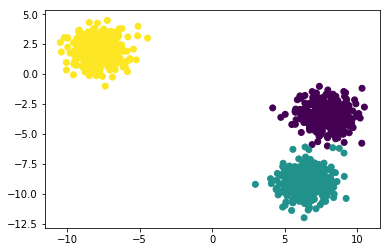

Accuracy:  0.998


In [11]:
my_clf = MyDecisionTreeClassifier(criterion='gini')
my_clf.fit(X_train, y_train)
y_predict = my_clf.predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict)
plt.show()

print 'Accuracy: ', accuracy_score(y_test, y_predict)


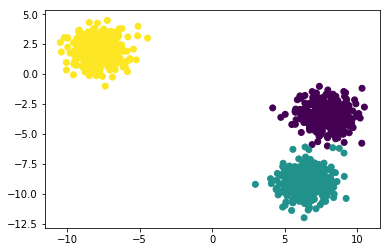

Accuracy:  0.998


In [12]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

plt.scatter(X_test[:, 0], X_test[:, 1], c=y_predict)
plt.show()

print 'Accuracy: ', accuracy_score(y_test, y_predict)


In [7]:
gkf = KFold(n_splits=5, shuffle=True)


In [8]:
for train, test in gkf.split(x, y):
    
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    
    print (accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    

0.932734680303
0.933981874117
0.931986364014
0.932069510269
0.930029518147


In [9]:
for train, test in gkf.split(x, y):
    
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    
    print (accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
    

0.891369418808
0.891161553172
0.893240209529
0.891286272553
0.894233567538
